In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import gc

In [2]:
TRAIN_FILE           = "data/train.parquet"
TEST_FILE            = "data/test.parquet"
starter_ch = [f"channel_{i}" for i in range(41,47)]

In [3]:
# Función de imputación de gaps (0.0 → NaN → LOCF+BOCB)
def impute_zeros(df, channels):
    cz = [c for c in channels if (df[c]==0.0).any()]
    df[cz] = df[cz].replace(0.0, np.nan)
    df[cz] = df[cz].ffill().bfill()
    return df

# Carga
df   = pd.read_parquet(TRAIN_FILE, columns=["id","is_anomaly"] + starter_ch)
df_t = pd.read_parquet(TEST_FILE,  columns=["id"] + starter_ch)

# Imputación
df   = impute_zeros(df,   starter_ch)
df_t = impute_zeros(df_t, starter_ch)

In [4]:
scaler_raw = StandardScaler()
df[starter_ch]   = scaler_raw.fit_transform(df[starter_ch])
df_t[starter_ch] = scaler_raw.transform(df_t[starter_ch])

In [5]:
WINDOW_SIZE = 60
N_VENTANAS = 500000

# Función de creación de ventanas
def create_windows(X, window_size):
    return np.array([X[i:i + window_size] for i in range(len(X) - window_size + 1)])

# Extraer todos los registros nominales (sin anomalía)
X_train_raw = df[df["is_anomaly"] == 0.0][starter_ch].values
max_start = len(X_train_raw) - WINDOW_SIZE

# Selección aleatoria de inicios de ventana
np.random.seed(42)
idx = np.random.choice(max_start, size=N_VENTANAS, replace=False)

# Crear secuencias
X_train_seq = np.array([X_train_raw[i:i + WINDOW_SIZE] for i in idx])

print("Shape final X_train_seq:", X_train_seq.shape)

Shape final X_train_seq: (500000, 60, 6)


In [6]:
def build_lstm_autoencoder(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))
    encoded = LSTM(64, activation="tanh")(input_layer)
    repeated = RepeatVector(seq_len)(encoded)
    decoded = LSTM(64, activation="tanh", return_sequences=True)(repeated)
    output_layer = TimeDistributed(Dense(n_features))(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mse")
    return model

n_features = X_train_seq.shape[2]
model = build_lstm_autoencoder(seq_len=WINDOW_SIZE, n_features=n_features)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 repeat_vector (RepeatVector  (None, 60, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 60, 6)            390       
 ibuted)                                                         
                                                                 
Total params: 51,590
Trainable params: 51,590
Non-trainable p

In [7]:
history = model.fit(
    X_train_seq, X_train_seq,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/30
3516/3516 [==============================] - 54s 14ms/step - loss: 0.0125 - val_loss: 0.0114
Epoch 2/30
3516/3516 [==============================] - 45s 13ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 3/30
3516/3516 [==============================] - 47s 13ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 4/30
3516/3516 [==============================] - 45s 13ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/30
3516/3516 [==============================] - 48s 14ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 6/30
3516/3516 [==============================] - 47s 13ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 7/30
3516/3516 [==============================] - 47s 13ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 8/30
3516/3516 [==============================] - 45s 13ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 9/30
3516/3516 [==============================] - 48s 14ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 10/30
3516/3516 [==============================] - 49s 14m

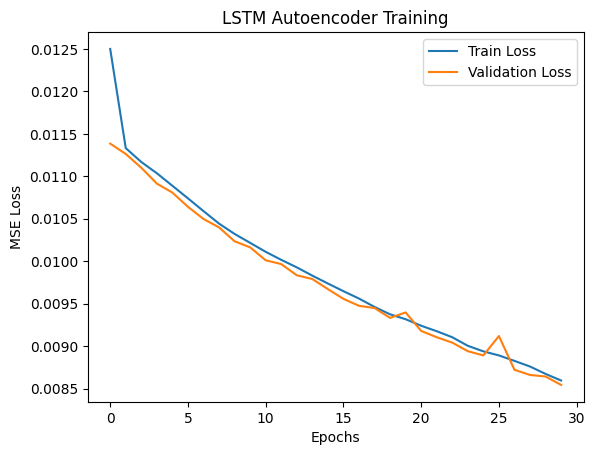

In [8]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("LSTM Autoencoder Training")
plt.show()

In [21]:
# Selección de los últimos 1M de registros del train (con anomalías reales)
WINDOW_SIZE = 60
VALID_SIZE = 1_000_000

val_df = df.iloc[-VALID_SIZE:]
X_val_raw = val_df[starter_ch].values
y_val_raw = val_df["is_anomaly"].values

# Crear ventanas de validación y etiquetas alineadas
X_val_seq = np.array([X_val_raw[i:i+WINDOW_SIZE] for i in range(len(X_val_raw) - WINDOW_SIZE + 1)])
y_val_trimmed = y_val_raw[WINDOW_SIZE - 1:]

print("Shape X_val_seq:", X_val_seq.shape)
print("Shape y_val_trimmed:", y_val_trimmed.shape)

Shape X_val_seq: (999941, 60, 6)
Shape y_val_trimmed: (999941,)


In [23]:
# Reconstrucción con el modelo entrenado
def batch_predict(model, X, batch_size=1024):
    preds = []
    for i in range(0, len(X), batch_size):
        preds.append(model.predict(X[i:i+batch_size], verbose=0))
    return np.concatenate(preds, axis=0)

X_val_pred = batch_predict(model, X_val_seq)

# Error de reconstrucción (MSE por ventana)
reconstruction_errors_val = np.mean(np.mean(np.square(X_val_seq - X_val_pred), axis=2), axis=1)

print("Reconstruction errors shape:", reconstruction_errors_val.shape)


Reconstruction errors shape: (999941,)


In [24]:
def event_wise_fbeta_score(y_true, y_pred, beta=0.5):
    def get_events(y):
        ev, in_ev = [], False
        for i,v in enumerate(y):
            if v and not in_ev:
                start, in_ev = i, True
            elif not v and in_ev:
                ev.append((start, i-1)); in_ev=False
        if in_ev: ev.append((start, len(y)-1))
        return ev

    true_ev = get_events(y_true)
    pred_ev = get_events(y_pred)
    TPe = sum(1 for a,b in true_ev if np.any(y_pred[a:b+1]==1))
    FNe = len(true_ev)-TPe
    FPe = sum(1 for a,b in pred_ev if not np.any(y_true[a:b+1]==1))
    FP_pts = np.sum((y_pred==1)&(y_true==0))
    N_nom   = np.sum(y_true==0)
    prec = TPe / (TPe + FPe + FP_pts/max(1, N_nom))
    rec  = TPe / max(1,TPe+FNe)
    b2   = beta**2
    return 0.0 if (prec+rec)==0 else (1+b2)*prec*rec/(b2*prec+rec)

# Evaluar muchos umbrales posibles
percentiles = np.linspace(99, 99.99, 100)
thresholds = np.percentile(reconstruction_errors_val, percentiles)

mejor_fbeta = 0
mejor_umbral = None

for thr in thresholds:
    y_pred = (reconstruction_errors_val > thr).astype(int)
    fscore = event_wise_fbeta_score(y_val_trimmed, y_pred)
    print(f"Threshold @ {thr:.6f} → F0.5 = {fscore:.4f}")
    if fscore > mejor_fbeta:
        mejor_fbeta = fscore
        mejor_umbral = thr

print(f"\n✅ Mejor umbral: {mejor_umbral:.6f} con F0.5 = {mejor_fbeta:.4f}")


Threshold @ 0.011111 → F0.5 = 0.0106
Threshold @ 0.011116 → F0.5 = 0.0106
Threshold @ 0.011123 → F0.5 = 0.0108
Threshold @ 0.011130 → F0.5 = 0.0109
Threshold @ 0.011136 → F0.5 = 0.0112
Threshold @ 0.011142 → F0.5 = 0.0113
Threshold @ 0.011149 → F0.5 = 0.0115
Threshold @ 0.011156 → F0.5 = 0.0117
Threshold @ 0.011163 → F0.5 = 0.0119
Threshold @ 0.011170 → F0.5 = 0.0121
Threshold @ 0.011176 → F0.5 = 0.0123
Threshold @ 0.011182 → F0.5 = 0.0124
Threshold @ 0.011189 → F0.5 = 0.0124
Threshold @ 0.011198 → F0.5 = 0.0125
Threshold @ 0.011204 → F0.5 = 0.0127
Threshold @ 0.011210 → F0.5 = 0.0128
Threshold @ 0.011217 → F0.5 = 0.0129
Threshold @ 0.011224 → F0.5 = 0.0132
Threshold @ 0.011232 → F0.5 = 0.0134
Threshold @ 0.011241 → F0.5 = 0.0134
Threshold @ 0.011251 → F0.5 = 0.0137
Threshold @ 0.011259 → F0.5 = 0.0139
Threshold @ 0.011266 → F0.5 = 0.0140
Threshold @ 0.011274 → F0.5 = 0.0142
Threshold @ 0.011282 → F0.5 = 0.0146
Threshold @ 0.011291 → F0.5 = 0.0146
Threshold @ 0.011298 → F0.5 = 0.0147
T

In [26]:
# A partir de df_t imputado
X_test_raw = df_t[starter_ch].values  # ← starter_ch ya estaba definido

# Crear ventanas para test
X_test_seq = np.array([
    X_test_raw[i:i+WINDOW_SIZE] 
    for i in range(len(X_test_raw) - WINDOW_SIZE + 1)
])

print("✅ X_test_seq shape:", X_test_seq.shape)

✅ X_test_seq shape: (521221, 60, 6)


In [28]:
# Usar predicción por lotes para evitar errores de memoria
X_test_pred = batch_predict(model, X_test_seq, batch_size=512)

# Error de reconstrucción (MSE por ventana)
reconstruction_errors_test = np.mean(np.mean(np.square(X_test_seq - X_test_pred), axis=2), axis=1)

# Aplicar mejor umbral encontrado
best_threshold = 0.013910
y_pred_final = (reconstruction_errors_test > best_threshold).astype(int)

In [30]:
# Predicción ya generada: y_pred_final (longitud n - w + 1)
n_missing = WINDOW_SIZE - 1
padding = np.zeros(n_missing, dtype=int)  # asumimos que no hay anomalía

# Completar predicciones
y_pred_kaggle = np.concatenate([padding, y_pred_final])

# Confirmamos longitud
assert len(y_pred_kaggle) == len(df_t), "❌ El número de predicciones no coincide con df_t"

# Guardar CSV
submission = pd.DataFrame({
    "id": df_t["id"].values,
    "is_anomaly": y_pred_kaggle
})
submission.to_csv("submission_lstm.csv", index=False)
print("✅ Submission corregida y guardada")

✅ Submission corregida y guardada
